<h1> MixMatch

In [1]:
%reload_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
from fastai.vision import *
from fastai.callbacks import SaveModelCallback, EarlyStoppingCallback, CSVLogger
from CinemaNet.train_utils import *
from CinemaNet.custom_head import *
from CinemaNet.wandb import *
from CinemaNet.MixMatch import *

import wandb

In [3]:
#hide
wandb.init(name='mixmatch-resnet',
           project='shot-framing',
           tags=['WideResNet', 'MixMatch', 'fastai', 'PyTorch'],
           entity='synopsis',
           reinit=True)

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
Error generating diff: Command '['git', 'diff', '--submodule=diff', '747359307a168f411ffb9fcfe9d768f1d7920bfd']' timed out after 5 seconds


W&B Run: https://app.wandb.ai/synopsis/shot-framing/runs/b1u6juen

In [4]:
#hide
%env WANDB_NOTEBOOK_NAME='mixmatch-resnet.ipynb'

env: WANDB_NOTEBOOK_NAME='mixmatch-resnet.ipynb'


## Setup

Since MixMatch is all about using a little labelled data + lots of unlabelled data, we're gonna swap the train and valid datasets. This way, we have 600 labelled images (100 per class), and 5505 validation images. The unlabelled images will come from the rest of the FilmGrab dataset.

In [5]:
path = Path('/home/rahul/github_projects/CinemaNet/')

In [6]:
config = wandb.config

config.img_size=to_film_ar(150)
config.batch_size=8
config.model='WideResNet'
config.mixup='True'
config.mixmatch='True'

Error generating diff: Command '['git', 'diff', '--submodule=diff', '747359307a168f411ffb9fcfe9d768f1d7920bfd']' timed out after 5 seconds


In [8]:
data = ImageDataBunch.from_folder(path, 
                                  train='valid', valid='train', # swapping train & valid datasets
                                  bs = config.batch_size,
                                  size = tuple(config.img_size),
                                  ds_tfms = get_transforms(max_zoom=1.),
                                  resize_method = ResizeMethod.SQUISH
                                 ).normalize(imagenet_stats) 

In [9]:
data.c
data

6

ImageDataBunch;

Train: LabelList (600 items)
x: ImageList
Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266)
y: CategoryList
Medium,Medium,Medium,Medium,Medium
Path: /home/rahul/github_projects/CinemaNet;

Valid: LabelList (5505 items)
x: ImageList
Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266)
y: CategoryList
Medium,Medium,Medium,Medium,Medium
Path: /home/rahul/github_projects/CinemaNet;

Test: None

In [11]:
data.train_dl.batch_size
data.valid_dl.batch_size

8

8

In [12]:
ls ../

CinemaNet/                               filmgrab/  settings.ini  valid/
LICENSE                                  models/    setup.py      wandb/
WideResNet-img_100-MixMatch-history.csv  nbs/       train/


In [13]:
data_unlabelled = ImageList.from_folder(path/'filmgrab')
data_unlabelled

ImageList (95329 items)
Image (3, 576, 1024),Image (3, 576, 1024),Image (3, 576, 1024),Image (3, 576, 1024),Image (3, 576, 1024)
Path: /home/rahul/github_projects/CinemaNet/filmgrab

In [14]:
config.valid_size = len(data.valid_ds)
config.train_size = len(data.train_ds)
config.unlabelled_size = len(data_unlabelled)

Error generating diff: Command '['git', 'diff', '--submodule=diff', '747359307a168f411ffb9fcfe9d768f1d7920bfd']' timed out after 5 seconds


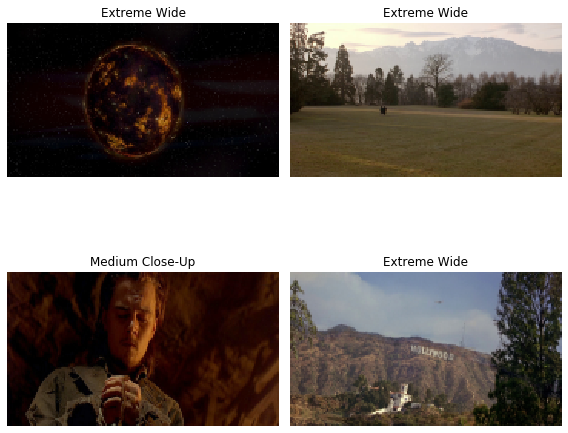

In [12]:
data.show_batch(rows=2)

### MixMatch

In [15]:
model = models.WideResNet(num_groups=3, N=4, num_classes=data.c, k=2, start_nf=32)
learn = Learner(data, model, metrics=metrics).mixmatch(data_unlabelled, α=.75, λ=75, size=config.img_size)

In [16]:
learn.data

ImageDataBunch;

Train: MultiTfmLabelList (95329 items)
x: ImageList
[Image (3, 150, 266), Image (3, 150, 266)],[Image (3, 150, 266), Image (3, 150, 266)],[Image (3, 150, 266), Image (3, 150, 266)],[Image (3, 150, 266), Image (3, 150, 266)],[Image (3, 150, 266), Image (3, 150, 266)]
y: EmptyLabelList
,,,,
Path: /home/rahul/github_projects/CinemaNet/filmgrab;

Valid: LabelList (5505 items)
x: ImageList
Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266)
y: CategoryList
Medium,Medium,Medium,Medium,Medium
Path: /home/rahul/github_projects/CinemaNet;

Test: None

In [17]:
learn.data.batch_size

8

In [18]:
learn.data.train_dl.batch_size
learn.data.valid_dl.batch_size

8

16

In [19]:
import functools, traceback
def gpu_mem_restore(func):
    "Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except:
            type, val, tb = sys.exc_info()
            traceback.clear_frames(tb)
            raise type(val).with_traceback(tb) from None
    return wrapper

In [20]:
class gpu_mem_restore_ctx():
    " context manager to reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"
    def __enter__(self): return self
    def __exit__(self, exc_type, exc_val, exc_tb):
        if not exc_val: return True
        traceback.clear_frames(exc_tb)
        raise exc_type(exc_val).with_traceback(exc_tb) from None

In [21]:
torch.cuda.empty_cache()

labeled dataset     :           600 samples
unlabeled dataset   :        95,329 samples
total train samples :       285,984 samples


epoch,train_loss,valid_loss,accuracy,precision,recall,train_Lx,train_Lu*λ,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


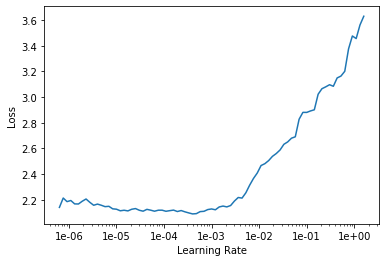

In [22]:
learn.lr_find()
learn.recorder.plot()

In [23]:
len(learn.layer_groups)

1

**NOTE:** Cannot use differential learning rates since the model isn't divided into layer groups by default

`WandbCallback` doesn't seem to work with `WideResNet`. See https://github.com/wandb/client/issues/777

In [24]:
def get_callbacks(learner, mod_name, early_stop=True, patience=5, monitor='accuracy', min_delta=0.01):
    callbacks=[
        SaveModelCallback(learner, every='improvement', name=f'{mod_name}-opt_accuracy', monitor='accuracy'),
        SaveModelCallback(learner, every='improvement', name=f'{mod_name}-opt_val_loss'),
        CSVLogger        (learner, filename=f'{mod_name}-history'),
        WandbCallback    (learner, monitor=monitor, input_type='images', log='all')
    ]
    if early_stop: callbacks.append(EarlyStoppingCallback(learner, patience=patience, min_delta=min_delta, monitor=monitor))
    return callbacks

In [25]:
model_name = 'WideResNet-img_100-MixMatch'
callbacks = get_callbacks(learn, model_name)

In [26]:
learn.save('WideResNet-img_100-MixMatch-opt_accuracy')

In [27]:
torch.cuda.empty_cache()

### bo

In [ ]:
with gpu_mem_restore_ctx():
    learn.fit_one_cycle(100, 1e-3, callbacks=[WandbCallback(learn, log='all')])

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,1.699285,1.872010,0.237057,0.222091,0.269832,01:15
1,1.649636,1.837421,0.249046,0.213722,0.275461,01:02
2,1.591853,1.837914,0.255041,0.250641,0.276063,01:07
3,1.555390,1.931340,0.269210,0.269462,0.298856,01:05
4,1.514812,1.942410,0.293733,0.304017,0.319528,01:05
5,1.477936,1.801882,0.297003,0.318923,0.322443,01:04
6,1.424440,1.818093,0.329700,0.334217,0.344859,01:05
7,1.398673,1.808135,0.336966,0.338598,0.349438,01:06
8,1.360407,1.566182,0.366576,0.385416,0.385411,01:05
9,1.339059,1.611485,0.394732,0.402409,0.402708,01:05


Error generating diff: Command '['git', 'diff', '--submodule=diff', '747359307a168f411ffb9fcfe9d768f1d7920bfd']' timed out after 5 seconds


Better model found at epoch 0 with valid_loss value: 1.872009515762329.


/home/rahul/fastai/fastai/metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


Better model found at epoch 1 with valid_loss value: 1.8374207019805908.
Better model found at epoch 5 with valid_loss value: 1.8018817901611328.
Better model found at epoch 8 with valid_loss value: 1.566182017326355.
Better model found at epoch 15 with valid_loss value: 1.5475058555603027.
Better model found at epoch 17 with valid_loss value: 1.3828818798065186.
Better model found at epoch 34 with valid_loss value: 1.344443440437317.
Better model found at epoch 35 with valid_loss value: 1.3202942609786987.
Better model found at epoch 47 with valid_loss value: 1.270851492881775.
